In [1]:
import os
import glob
import random

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import torch
from torch.nn import functional as F
import torchvision.transforms as T

from model import GarbageModel
from util import pil_loader, prepare_image

c:\Users\LUKE_SARGEN\anaconda3\envs\pytorch110cu113\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\LUKE_SARGEN\anaconda3\envs\pytorch110cu113\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\LUKE_SARGEN\anaconda3\envs\pytorch110cu113\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
chkp_path = "logs/subset/version_87/last.ckpt"
out_suffix = "_87"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device : {device}")
model = GarbageModel.load_from_checkpoint(chkp_path, map_location=device)
model.eval()
model.freeze()
model.to(device)
features = model.model.features
attention = model.model.attention
classes = model.hparams.classes
model.hparams.model

Device : cuda:0


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to C:\Users\LUKE_SARGEN/.cache\torch\hub\checkpoints\mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:01<00:00, 9.13MB/s]


'mobilenet_v3_small.attn'

In [3]:
root = r"C:\Users\LUKE_SARGEN\projects\datasets\memes\samples"
image_types = ["*.jpg", "*.png", "*.jpeg"]
images = [f for ext in image_types for f in glob.glob(os.path.join(root, ext))]

img_path='C:\\Users\\LUKE_SARGEN\\projects\\datasets\\memes\\samples\\frog_bowl.jpg'
Original Size : (750, 750)
 Resized Size : (256, 256)


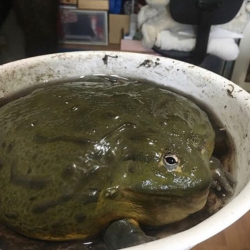

In [5]:
img_path = random.choice(images)
img_path = r"C:\Users\LUKE_SARGEN\projects\datasets\memes\samples\frog_bowl.jpg"
print(f"{img_path=}")

input_size = 256
img_color = pil_loader(img_path)
print(f"Original Size : {img_color.size}")
resized = T.Resize(input_size)(img_color)
print(f" Resized Size : {resized.size}")
img_ten = prepare_image(img_color, input_size).to(device)
T.Resize(250)(img_color)

In [6]:
attns = []
with torch.no_grad():
    feats = features(img_ten.clone())
    tokens = attention.features_to_tokens(feats)
    for block in attention.blocks:
        # Rebuild the forward here
        residual, attn = block.attention(tokens)
        attns.append(attn.detach().cpu())
        if block.mlp is not None:
            residual = residual + block.mlp(tokens)
        residual = block.dropout(residual)
        tokens = block.ln(residual + tokens)
    logits = attention.out(tokens[:,0])
    yclass = torch.softmax(logits, dim=1)
n, heads, t, _ = attn.shape
n, c, fh, fw = feats.shape
stack = torch.cat(attns)
print(f"{stack.shape=}")
block_avg = stack.mean(dim=(1), keepdim=True)
print(f"{block_avg.shape=}")
total_avg = block_avg.mean(dim=0, keepdim=True).expand(len(attns), -1, -1, -1)
print(f"{total_avg.shape=}")
stack = torch.cat([total_avg, block_avg, stack], dim=1)
print(f"{stack.shape=}")
print(f" Feats : ({feats.shape[2]}, {feats.shape[3]})")
print(f"Blocks : {len(attns)}")
print(f" Heads : {attns[0].shape[1]}")
print(f"Tokens : {tokens.shape[1]}")
for c, p in zip(classes, yclass[0]):
    print(f"{c:>4}: {100*p:7.02f} %")

stack.shape=torch.Size([1, 8, 65, 65])
block_avg.shape=torch.Size([1, 1, 65, 65])
total_avg.shape=torch.Size([1, 1, 65, 65])
stack.shape=torch.Size([1, 10, 65, 65])
 Feats : (8, 8)
Blocks : 1
 Heads : 8
Tokens : 65
mmmm:    1.85 %
 nah:   95.38 %
nnnn:    0.73 %
oooo:    0.10 %
qqqq:    1.95 %


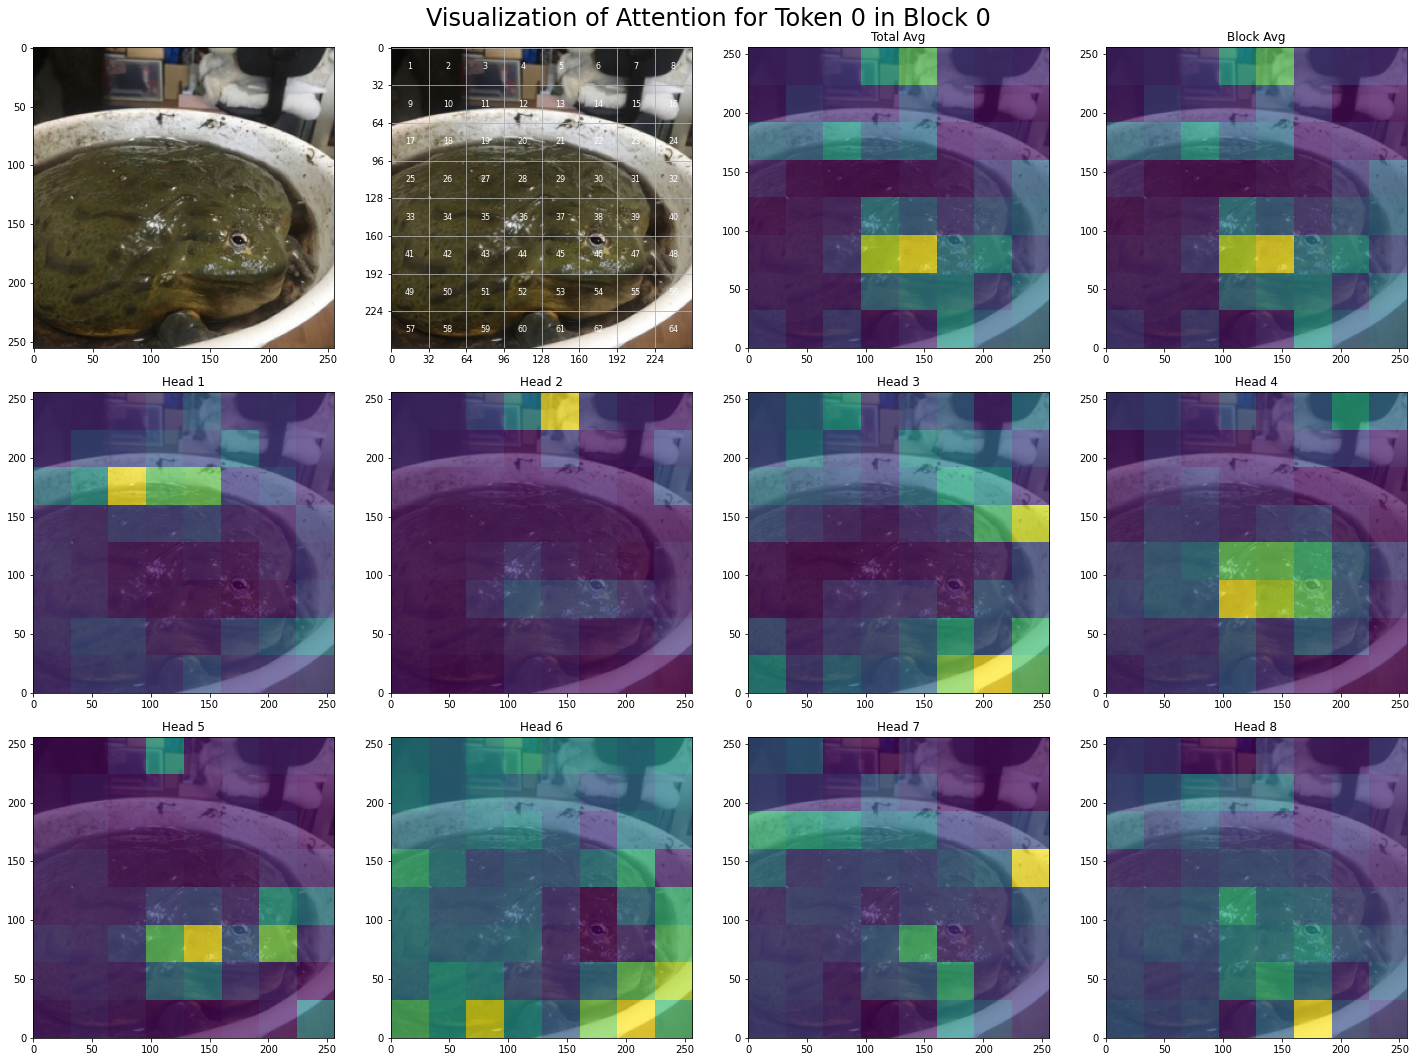

In [10]:
token = 0  # 0=cls
cols = 4
scale = 5

for block in range(len(attns)):
    attn = stack[block]
    rw, rh = resized.size
    rows = 1+(heads+3)//cols  # +4-1=+3 for original image, grid numbers, total avg, block avg
    fig = plt.figure(figsize=(cols*scale, rows*scale))
    fig.suptitle(f"Visualization of Attention for Token {token} in Block {block}", fontsize=24)
    ax = fig.add_subplot(rows, cols, 1)
    ax.imshow(resized)  # Original
    ax = fig.add_subplot(rows, cols, 2)
    ax.imshow(resized)  # Original + grid numbers
    extent = 0, rw, 0, rh
    sx, sy = rw/fw, rh/fh
    patch = 1
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=sx))
    ax.yaxis.set_major_locator(plticker.MultipleLocator(base=sy))
    ax.grid(which='major', axis='both', linestyle='-')
    for y in range(fh):
        cy = sy/2 + y*sy
        for x in range(fw):
            cx = sx/2 + x*sx
            ax.text(cx, cy, f"{patch:d}", fontsize=8, color='w', ha='center', va='center')
            patch += 1
    for h in range(heads+2):  # +2 for total avg and block avg
        attn_weights = attn[h,token][1:]  # Slice token row, then remove the cls token
        attn_weights = attn_weights.reshape(fh, fw) #.unsqueeze_(0).unsqueeze_(0)
        # attn_weights = F.interpolate(attn_weights, size=(rh,rw), mode='bilinear', align_corners=True).squeeze_(0).squeeze_(0)
        attn_weights -= attn_weights.min()
        attn_weights /= attn_weights.max()
        # Create pil from mask and blend with resized
        ax = fig.add_subplot(rows, cols, h+3)
        title_str = f"{'Total' if h==0 else 'Block'} Avg" if h in [0,1] else f"Head {h-1}"
        ax.set_title(title_str)
        ax.imshow(resized, extent=extent)
        ax.imshow(attn_weights, alpha=0.7, extent=extent)
    fig.tight_layout()
    fig.patch.set_facecolor('white')
    out_path = f"data/outputs/{os.path.basename(img_path).split('.')[0]}_input_{input_size}_token_{token}_block_{block}{out_suffix}.png"
    plt.savefig(out_path, bbox_inches="tight")
    # plt.close()
    # break  # Does only the first layer
plt.show()